# Fraud Detection

In [6]:
## Imports:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_validate, learning_curve, StratifiedKFold, RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score, classification_report

## Dataset exploration

### [Dataset](https://www.kaggle.com/datasets/chitwanmanchanda/fraudulent-transactions-data) Description: Fraudulent Transactions Prediction

### Context  
The dataset supports the development of a model to predict fraudulent transactions for a financial company. Insights derived from the model are intended to inform an actionable plan. The data is in CSV format, containing **6,362,620 rows** and **10 columns**, simulating 30 days of transactions.

### Content  
The dataset includes the following features:

- **`step`**: Time unit in hours (1 step = 1 hour, total steps = 744).
- **`type`**: Type of transaction - `CASH-IN`, `CASH-OUT`, `DEBIT`, `PAYMENT`, `TRANSFER`.
- **`amount`**: Transaction amount in local currency.
- **`nameOrig`**: Customer initiating the transaction.
- **`oldbalanceOrg`**: Initial balance of the sender before the transaction.
- **`newbalanceOrig`**: New balance of the sender after the transaction.
- **`nameDest`**: Recipient of the transaction.
- **`oldbalanceDest`**: Initial balance of the recipient before the transaction (missing for merchants, indicated by names starting with "M").
- **`newbalanceDest`**: New balance of the recipient after the transaction (missing for merchants).
- **`isFraud`**: Indicates if the transaction was fraudulent (simulated fraudulent behavior involves taking control of accounts to transfer and withdraw funds).
- **`isFlaggedFraud`**: Flags illegal attempts, defined as transferring amounts exceeding 200,000 in a single transaction.


In [9]:
data = pd.read_csv('raw_data/Fraud.csv')

print(f"Shape: {data.shape}")
data.head(3)

# Features and target
X = data.drop(columns=['isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest'])
y = data['isFraud']

Shape: (6362620, 11)


In [ ]:
# Checking for null values
data.isna().sum()

In [ ]:
data.info()

In [ ]:
# Check for class imbalance
non_fraudulent = len(data[data['isFraud'] == 0])
fraudulent = len(data[data['isFraud'] == 1])

non_fraudulent_perc = np.round(non_fraudulent/data.shape[0], decimals=4)
fraudulent_perc = np.round(fraudulent/data.shape[0], decimals=4)

print(f"Non-fraudulent transactions: {non_fraudulent}\nFraudulent transactions: {fraudulent}")

print("_"*100)

print(f"Non-fraudulent transactions: {non_fraudulent_perc}\nFraudulent transactions: {fraudulent_perc}")

In [6]:
# Checking if all FlaggedFrauds are classified as 1 in isFrauds column
assert len(data[(data['isFlaggedFraud'] == 1) & (data['isFraud'] == 1)]) == len(data[data['isFlaggedFraud'] == 1])

In [ ]:
for col in ['type', '']:
    print(data[col].unique)

### EDA

In [23]:
def plot_isfraud_value_count(data : pd.DataFrame) -> None:
    """
    Plots a bar chart showing the counts of unique values in the 'isFraud' column of a DataFrame.

    This function creates a bar plot using Seaborn to visualize the distribution of values (0 and 1)
    in the 'isFraud' column of the given DataFrame. The chart includes:
    - Custom annotations above each bar displaying the exact count.
    - Customized y-axis tick labels for better readability.
    - A title and axis labels for clarity.

    Parameters:
    -----------
    data : pd.DataFrame
        A pandas DataFrame containing the 'isFraud' column with binary values (0 and 1).

    Returns:
    --------
    None
        This function displays the plot but does not return any value.

    Notes:
    ------
    - The function assumes the 'isFraud' column exists in the DataFrame and contains binary values.
    - The y-axis tick intervals are set to 1,000,000 by default and may require adjustment for datasets
      with smaller counts.
    """
    value_counts = data['isFraud'].value_counts()

    ax = sns.barplot(x=value_counts.index, y=value_counts.values, color='maroon')

    for index, value in enumerate(value_counts.values):
        ax.text(index, value + max(value_counts.values) * 0.02,
                str(value),
                ha='center', fontsize=12, fontweight='bold')

    ax.set_yticks(range(0, max(value_counts.values) + 1, 1000000))
    ax.set_yticklabels([f"{tick}" for tick in ax.get_yticks()])
    plt.xlabel('isFraud')
    plt.ylabel('Count')
    plt.title('Value count in isFraud Column')
    plt.ylim(0, max(value_counts.values) * 1.1)
    plt.show()

    return None

In [ ]:
#plot_isfraud_value_count(data)

In [24]:
# checking for correlations in numerical features:

def plot_correlation_map(data: pd.DataFrame) -> None:
    """
    Plots a heatmap of the correlation matrix for a given DataFrame.

    This function computes the correlation matrix of the numeric columns in the input DataFrame,
    then visualizes it using a heatmap with the upper triangle masked. The heatmap displays
    correlation coefficients as annotated values.

    Parameters:
    -----------
    data : pd.DataFrame
        The input DataFrame containing numeric data for which the correlation matrix is calculated.

    Returns:
    --------
    None
        This function does not return any value. It displays a heatmap plot of the correlation matrix.
    """
    corr = data.corr(numeric_only=True)
    trimask = np.triu(np.ones_like(corr, dtype=bool))

    sns.heatmap(data=corr, annot=True, mask=trimask,square=True, linewidth=.1, fmt=".2f")

    plt.tight_layout()
    plt.show()

In [ ]:
plot_correlation_map(data)

## Preprocessing

### UnderSampling

In [ ]:
# Criar o balanceador
undersample = RandomUnderSampler(sampling_strategy='auto')

# Under-sampling
X_res, y_res = undersample.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, stratify=y_res)

print(f"""
      X_train: {X_train.shape}
      X_test: {X_test.shape}
      y_train: {y_train.shape}
      y_test: {y_test.shape}
      """)

In [ ]:
y_train.value_counts(), y_test.value_counts()

In [81]:
numeric_columns = make_column_selector(dtype_include=['int64', 'float64'])
categorical_columns = make_column_selector(dtype_include=['object'])

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

full_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression())
])

In [ ]:
full_pipe.fit(X_train, y_train)

In [ ]:
cv = StratifiedKFold(n_splits=5)

cross_val = cross_validate(full_pipe, X_test, y_test, scoring = ['accuracy', 'recall', 'precision', 'average_precision'], cv=cv)
cross_val

print(f"Accuracy : {cross_val['test_accuracy'].mean()}")
print(f"Recall : {cross_val['test_recall'].mean()}")
print(f"Precision : {cross_val['test_precision'].mean()}")
print(f"AVG_Precision : {cross_val['test_average_precision'].mean()}")

In [ ]:
y_test_pred = full_pipe.predict(X_test)
print(classification_report(y_test, y_test_pred))

In [ ]:
full_pipe.fit(X_train, y_train)
y_pred_prob = full_pipe.predict_proba(X_test)[:,1]


precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(
    full_pipe, X_res, y_res, cv=cv, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 20)
)

plt.plot(train_sizes, train_scores.mean(axis=1), label='Train Score')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Test Score')
plt.legend()
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.show()


### UnderSampling + OverSampling

In [7]:
# Selecting columns by type
numeric_columns = make_column_selector(dtype_include=['int64', 'float64'])
categorical_columns = make_column_selector(dtype_include=['object'])

# Standard scaling for  the numerical features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# OHE for categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Preprocessing column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)

# Creating model
model = XGBClassifier(
    gamma=0.1,
    learning_rate=0.1,
    n_estimators=500,
    reg_lambda=1.0,
    max_depth=6,
)

# Full pipe including SMOTE + UnderSampler
full_pipe = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(sampling_strategy=0.5)),
    ('undersample', RandomUnderSampler(sampling_strategy=0.5)),
    ('model', model)
])


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify= y)

In [11]:
full_pipe.fit(X_train, y_train)

y_pred = full_pipe.predict(X_test)

In [29]:
# Metrics in the test dataset
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"""
      Accuracy: {round(accuracy, 2)}
      Recall: {round(recall, 2)}
      Precision: {round(precision, 2)}
      F1 Score: {round(f1, 2)}
      ROC AUC: {round(roc_auc, 2)}
      """)



      Accuracy: 1.0
      Recall: 0.99
      Precision: 0.47
      F1 Score: 0.64
      ROC AUC: 0.99
      


In [13]:
# Stratified cross validation
cv = StratifiedKFold(n_splits=5)

cross_val = cross_validate(full_pipe, X_train, y_train, scoring = ['accuracy', 'recall', 'precision', 'average_precision'], cv=cv)

print(f"Accuracy : {cross_val['test_accuracy'].mean()}")
print(f"Recall : {cross_val['test_recall'].mean()}")
print(f"Precision : {cross_val['test_precision'].mean()}")
print(f"AVG_Precision : {cross_val['test_average_precision'].mean()}")

Accuracy : 0.9985848148141201
Recall : 0.9888675975328262
Precision : 0.4771510708668513
AVG_Precision : 0.9687974211263937


In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.47      0.99      0.64      2464

    accuracy                           1.00   1908786
   macro avg       0.74      0.99      0.82   1908786
weighted avg       1.00      1.00      1.00   1908786



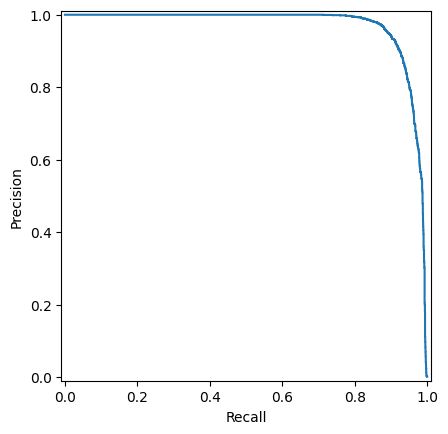

In [15]:
y_pred_prob = full_pipe.predict_proba(X_test)[:,1]

precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

In [26]:
# Calculating pred_proba for 0.9 threshold
threshold = 0.9
y_pred_adjusted = (y_pred_prob >= threshold).astype(int)
y_pred_adjusted

array([0, 0, 0, ..., 0, 0, 0], shape=(1908786,))

In [30]:
# Scoring with threshold adjustment
accuracy_9 = accuracy_score(y_test, y_pred_adjusted)
recall_9 = recall_score(y_test, y_pred_adjusted)
precision_9 = precision_score(y_test, y_pred_adjusted)
f1_9 = f1_score(y_test, y_pred_adjusted)
roc_auc_9 = roc_auc_score(y_test, y_pred_adjusted)

print("Before threshold adjustment:")

print(f"""
      Accuracy: {round(accuracy, 2)}
      Recall: {round(recall, 2)}
      Precision: {round(precision, 2)}
      F1 Score: {round(f1, 2)}
      ROC AUC: {round(roc_auc, 2)}
      """)
print("-" *50)
print("After threshold adjustment")

print(f"""
      Accuracy: {round(accuracy_9, 2)}
      Recall: {round(recall_9, 2)}
      Precision: {round(precision_9, 2)}
      F1 Score: {round(f1_9, 2)}
      ROC AUC: {round(roc_auc_9, 2)}
      """)

Before threshold adjustment:

      Accuracy: 1.0
      Recall: 0.99
      Precision: 0.47
      F1 Score: 0.64
      ROC AUC: 0.99
      
--------------------------------------------------
After threshold adjustment

      Accuracy: 1.0
      Recall: 0.96
      Precision: 0.73
      F1 Score: 0.83
      ROC AUC: 0.98
      


## Model Fine Tuning

In [ ]:
param_dist = {
    'model__learning_rate': [0.01, 0.1, 1],
    'model__n_estimators': [100, 200, 300, 400, 500],
    'model__max_depth': [3, 4, 5, 6, 7, 8, 9],
    'model__min_child_weight': [1, 2, 3, 4, 5],
    'model__subsample': [0.7, 0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'model__scale_pos_weight': [1, 2, 5, 10],
    'model__gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'model__reg_alpha': [0, 0.1, 0.5, 1],
    'model__reg_lambda': [0, 0.1, 0.5, 1],
    'smote__sampling_strategy': [0.3, 0.5, 0.7],
    'undersample__sampling_strategy': [0.3, 0.5, 0.7],
}

# Configuração do RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=full_pipe,
    param_distributions=param_dist,
    n_iter=50,
    scoring='precision',
    cv=cv,
    verbose=1,
    n_jobs=-1,
)

# Ajuste do modelo aos dados
random_search.fit(X_train, y_train)

In [ ]:
# Melhores parâmetros encontrados
print("Melhores parâmetros encontrados:", random_search.best_params_)

# Melhor modelo treinado
best_pipe = random_search.best_estimator_

# Avaliação do modelo nos dados de teste
precision = best_pipe.score(X_test, y_test)
print(f"Precision: {precision:.4f}")